In [145]:
import  numpy as np
import matplotlib.pyplot as plt

from qiskit import BasicAer, Aer, IBMQ

from qiskit.circuit import QuantumCircuit,QuantumRegister, ParameterVector
from qiskit.aqua.algorithms import VQE,  NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance

from qiskit.quantum_info.operators import Operator, Pauli


from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

In [146]:
#Exact solver for reference:
def Exact_solver(qubitOp):
    ex = NumPyEigensolver(qubitOp)
    result = ex.run()
    ref = result['eigenvalues']
    return np.real(ref)

In [147]:
backend = BasicAer.get_backend('qasm_simulator')

In [148]:
# Hidrogen (H_2)

basis='sto3g'
inter_dist=1.4
# Molecule
atoms = 'H .0 .0 .0; H .0 .0 '+str(inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis,max_memory=None)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))
#print('# one elctron integral:\n',h1)
#print('# two elctron integral:\n',h2)

ferOp = FermionicOperator(h1=h1, h2=h2)
qubitOp = ferOp.mapping(map_type='jordan_wigner')
print(qubitOp)
print(qubitOp.print_details())

weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label())
    
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e

HF energy: -1.3194643767935124
# nr. of electrons: 2
# nr. of spin orbitals: 4
Representation: paulis, qubits: 4, size: 15
IIII	(-0.8517840380466506+0j)
IIIZ	(0.10053557435398455+0j)
IIZI	(-0.049032364414860446+0j)
IZII	(0.10053557435398452+0j)
ZIII	(-0.04903236441486046+0j)
IIZZ	(0.08678749878785741+0j)
IZIZ	(0.14120468151365045+0j)
XXYY	(0.05575552226867875+0j)
YYYY	(0.05575552226867875+0j)
XXXX	(0.05575552226867875+0j)
YYXX	(0.05575552226867875+0j)
ZIIZ	(0.14254302105653616+0j)
IZZI	(0.14254302105653616+0j)
ZIZI	(0.14891189696596438+0j)
ZZII	(0.08678749878785741+0j)



In [149]:
params = ParameterVector('theta',nr_par+1)
print(params)

theta, ['theta[0]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]']


In [150]:
def var_circ_qiskit(nr_o,nr_e,params):
    
    circ = QuantumCircuit(nr_o)
    
    #initialize
    for i in range(nr_e):
        circ.x(i)
    
    #ansatz
    it=0
    start=nr_e-1
    limit=nr_o
    
    while start!=-1:
        
        cq=start
        tq=start+1
        
        while tq<limit:
            circ.cx(cq,tq)
            circ.z(cq)
            circ.cry((np.pi/2-params[it])*2,tq,cq)
            circ.cx(cq,tq)
            cq=cq+1
            tq=tq+1
            it=it+1

        start=start-1
        limit=limit-1
        
    return circ

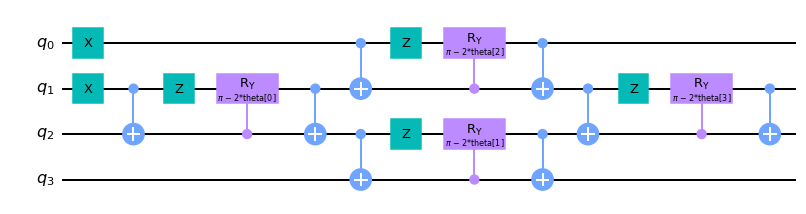

In [151]:
circ=var_circ_qiskit(nr_o,nr_e,params)
circ.draw('mpl')

In [152]:
def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)

In [153]:
seed= 125
shots=100
optim = COBYLA(maxiter=1000)

In [154]:
vqe= VQE(operator=qubitOp, var_form=circ, optimizer=optim,callback=store_intermediate_result)

In [155]:
counts=[]
values=[]
params=[]
deviation=[]


quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result_shots = vqe.run(quantum_instance)

VQE result: -1.3606029105023634
Exact solver: [-1.39345197]


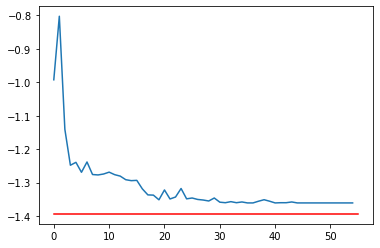

In [156]:
exact=Exact_solver(qubitOp)
print("VQE result:",values[-1])
print("Exact solver:",exact[0])

plt.plot(values)

x=np.linspace(0,len(values))
y=[exact for i in range(len(x))]
plt.plot(x, y, '-r', label='Ideal_value')

plt.show()